LAST UPDATED ON 2023/04/22

1. Data is downloaded from this [link](https://www.kaggle.com/datasets/andrewmvd/dog-and-cat-detection). The data size is around 1GB, contains 3686 cat and dog images with bounding box labels
2. Since the data size is quite small, then the data is just splitted into 2 sets training and validation. The training/validation split ratio is 0.9/0.1 for each class. 
3. Explore albumentation

# Import Libraries

In [1]:
import os
import cv2
import json
import numpy as np
import albumentations as A

from marco import *
from network import *
from visualise import *
from train_model import *
from prepare_data import *
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

# Define Flags

In [2]:
IS_SPLIT_CAT_AND_DOG = False
IS_SPLIT_TRAIN_AND_VALID = False

CLS2IND = {'cat': 0, 'dog': 1}
IND2CLS = {0: 'cat', 1: 'dog'}

# Obtain Image and Label Path

In [3]:
ROOT = 'cat_and_dog_det_data'

img_path = os.listdir(os.path.join(ROOT, 'images'))
lab_path = os.listdir(os.path.join(ROOT, 'annotations'))

img_path = [os.path.join(ROOT, 'images', file) for file in img_path if file.split('.')[-1] == 'png']
lab_path = [os.path.join(ROOT, 'annotations', file) for file in lab_path if file.split('.')[-1] == 'xml']

img_path, lab_path = sorted(img_path), sorted(lab_path)

# Split into Cat and Dog Folder

Training and validation data will be built up later on. So, 0.9/0.1 split ratio will be applied to cat and dog folder resepctively. Then, the distribution of classes in validation data and training data will be almost the same. 

In [4]:
if IS_SPLIT_CAT_AND_DOG:
    for img_load, lab_load in zip(img_path, lab_path):

        img = cv2.imread(img_load)
        img_h, img_w, _ = img.shape
        with open(lab_load, 'r') as f:
            data = f.read()
            
        bs_data = BeautifulSoup(data, 'xml')
        bs_objs = bs_data.find_all('object')
        boxes = []
        clses = []
        str_clses = []
        annotation  = {}
        
        for bs_obj in bs_objs:
            bs_cls = bs_obj.find('name').text
            bs_box = bs_obj.find('bndbox')
            x0 = float(bs_box.find('xmin').text)/img_w
            x1 = float(bs_box.find('xmax').text)/img_w
            y0 = float(bs_box.find('ymin').text)/img_h
            y1 = float(bs_box.find('ymax').text)/img_h

            cls = [0, 0]
            cls[CLS2IND[bs_cls]] = 1
            box = [x0, y0, x1, y1]
            boxes.append(box)
            clses.append(cls)
            str_clses.append(bs_cls)

        annotation['boxes'] = boxes
        annotation['class'] = clses
        
        cls_folder = np.unique(str_clses)[0]
        img_save = os.path.join(ROOT, cls_folder, img_load.split('/')[-1].replace('.png', '.jpg'))
        lab_save = os.path.join(ROOT, cls_folder, lab_load.split('/')[-1].replace('.xml', '.json'))
        cv2.imwrite(img_save, img)
        with open(lab_save, 'w') as f:
            json.dump(annotation, f)

# Split into training and validation folder

In [5]:
CAT_ROOT = os.path.join('cat_and_dog_det_data', 'cat')
DOG_ROOT = os.path.join('cat_and_dog_det_data', 'dog')

cat_path = os.listdir(CAT_ROOT)
dog_path = os.listdir(DOG_ROOT)

cat_path = [os.path.join(CAT_ROOT, file) for file in cat_path if file.split('.')[-1] == 'jpg']
dog_path = [os.path.join(DOG_ROOT, file) for file in dog_path if file.split('.')[-1] == 'jpg']

cat_train, cat_valid, _ = split_ids(cat_path, train = 0.9, valid = 0.1, test = 0.0)
dog_train, dog_valid, _ = split_ids(dog_path, train = 0.9, valid = 0.1, test = 0.0)

train_path = cat_train + dog_train
valid_path = cat_valid + dog_valid

In [6]:
N_train = len(train_path)
N_valid = len(valid_path)

print("N_cat: ", len(cat_path))
print("N_dog: ", len(dog_path))
print("N_train: ", N_train)
print("N_valid: ", N_valid)

assert len(cat_path) + len(dog_path) == N_train + N_valid

N_cat:  1174
N_dog:  2486
N_train:  3293
N_valid:  367


# Split into training and validation folder

In [7]:
if IS_SPLIT_TRAIN_AND_VALID:
    for folder in ['train', 'valid']:
        if folder == 'train':
            data_path = train_path
        elif folder == 'valid':
            data_path = valid_path
        for img_load in data_path:
            
            file_name  = (img_load.split('.')[0]).split('/')[-1]
            cls_folder = (img_load.split('.')[0]).split('/')[-2]
            img = cv2.imread(img_load)
            lab_load = os.path.join(ROOT, cls_folder, file_name + '.json')
            lab = json.load(open(lab_load))
            
            img_save = os.path.join(ROOT, folder, file_name + '.jpg')
            lab_save = os.path.join(ROOT, folder, file_name + '.json')
            
            cv2.imwrite(img_save, img)
            with open(lab_save, 'w') as f:
                json.dump(lab, f)

# Explore albumentation process during training

In [8]:
train_path = os.path.join("cat_and_dog_det_data", "train")
data_path  = os.listdir(train_path)

img_path = [os.path.join(CAT_ROOT, file) for file in data_path if file.split('.')[-1] == 'jpg']
lab_path = [os.path.join(DOG_ROOT, file) for file in data_path if file.split('.')[-1] == 'json']

img_path, lab_path = sorted(img_path), sorted(lab_path)


In [9]:
#define hyper - parameters
h_params = {}
#number of grids in one row/col
h_params['GRID_NUM'] = 7
#number of class
h_params['CLS_NUM'] = 2
#number of data in one batch
h_params['BATCH'] = BATCH
#number of data to be prefetched
h_params['PREFETCH'] = BATCH*2
#input image size of detector
h_params['DETECT_IMG_SIZE'] = DETECT_IMG_SIZE
#dropout ratio of fully connected layer
h_params['FC_DROPOUT_RATIO'] = 0.5

#define data to be loaded
data_folders = ['cat_and_dog_det_data'] 

train_img_list = []
valid_img_list = []

for i, data_folder in enumerate(data_folders):
    train_img_path = get_img_list(os.path.join(data_folder, 'train'))
    valid_img_path = get_img_list(os.path.join(data_folder, 'valid'))

    train_img_list = train_img_list + train_img_path
    valid_img_list = valid_img_list + valid_img_path
    
####### Get training, validation and testing image data #######
    
train_images = get_imgs(train_img_list, h_params['DETECT_IMG_SIZE'], h_params['DETECT_IMG_SIZE'])
valid_images = get_imgs(valid_img_list, h_params['DETECT_IMG_SIZE'], h_params['DETECT_IMG_SIZE'])

####### Get training, validation and testing labels #######
train_lab_list = get_label_list(train_img_list)
valid_lab_list = get_label_list(valid_img_list)

train_labels = get_labels(train_lab_list)
valid_labels = get_labels(valid_lab_list)

####### Combine labels and images #######
train = combine_imgs_and_labels(train_images, train_labels, h_params['BATCH'], h_params['PREFETCH'], is_shuffle = True)
valid = combine_imgs_and_labels(valid_images, valid_labels, h_params['BATCH'], h_params['PREFETCH'])

batches_train = len(train)
batches_valid = len(valid)

print('train batchs:', batches_train)
print('valid batchs:', batches_valid)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

train batchs: 206
valid batchs: 23


2023-05-02 05:40:20.007073: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-02 05:40:20.007166: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Check shape of batch data

In [10]:
train_iter = train.as_numpy_iterator()
imgs, labs = train_iter.next()

print('img.shape: ', imgs.shape)
print('lab.shape: ', labs[0].shape, labs[1].shape)

2023-05-02 05:40:20.143169: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


img.shape:  (16, 448, 448, 3)
lab.shape:  (16, 1, 2) (16, 1, 4)


# Transform batch data

This process involves three process

1. data augmentation
2. bounding boxes are transformed from "corner" format into "yolo" format
3. bounding boxes and class data are transformed into "cell" format for computing yolo loss

In [11]:
transform = A.Compose([
                        A.HorizontalFlip(),
                        A.RandomBrightnessContrast(),
                        #the image is normalized, so [0, 1]
                        A.HueSaturationValue(hue_shift_limit=[0., 0.], 
                                             sat_shift_limit=[0., 0.2], 
                                             val_shift_limit=[0., 0.]),
                        A.Affine(scale  = [0.8, 1], 
                                 translate_percent = (-0.15, 0.15),
                                 p = 1),
                      ], bbox_params=A.BboxParams(format='albumentations', 
                                                  min_visibility=0.5, 
                                                  label_fields=['category_ids']))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


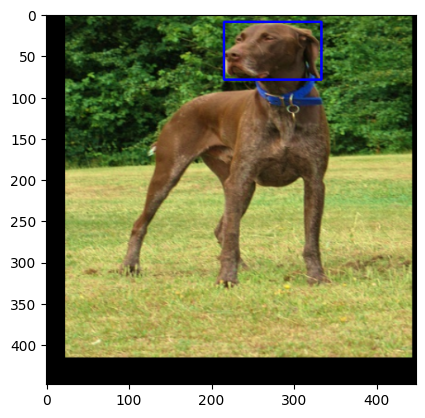

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


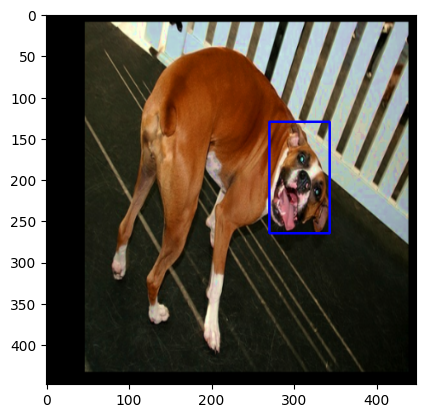

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


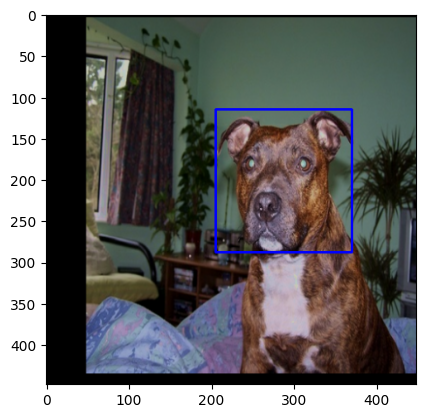

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


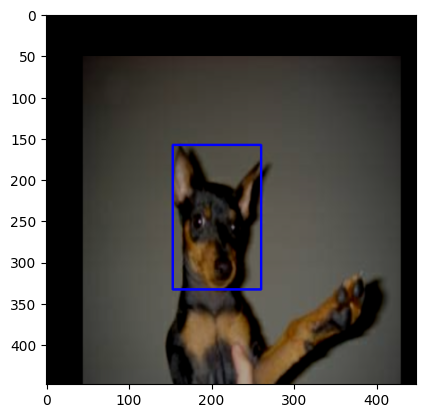

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


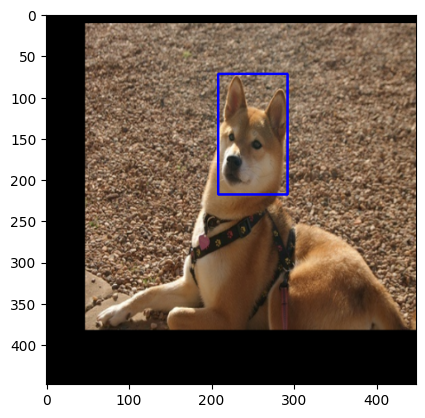

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


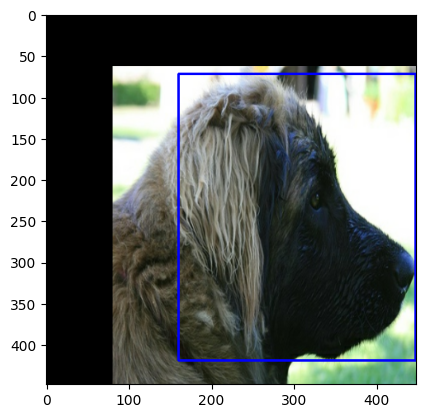

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


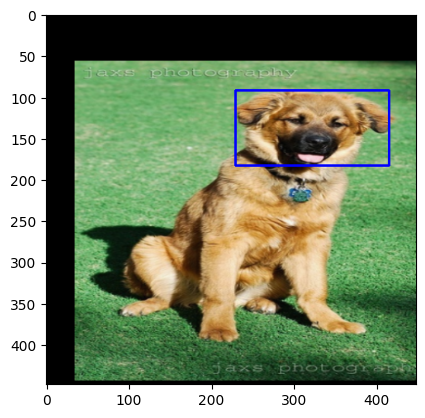

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


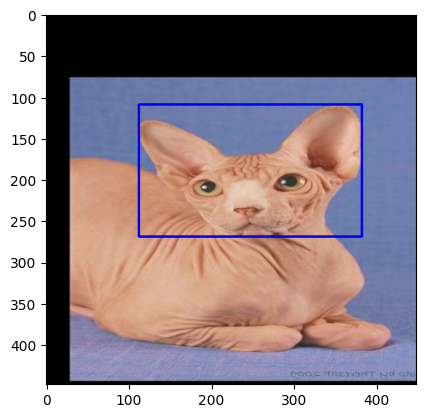

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


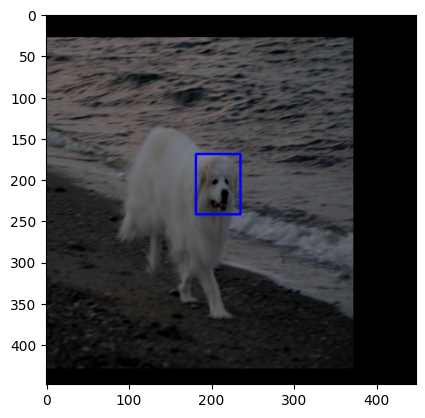

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


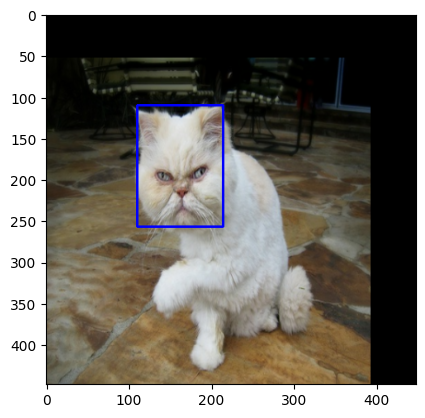

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


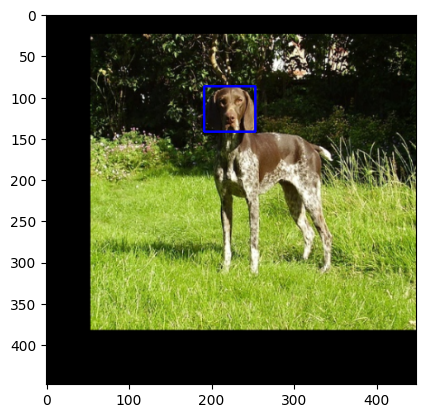

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


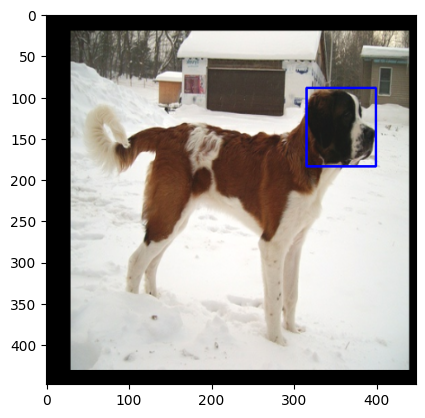

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


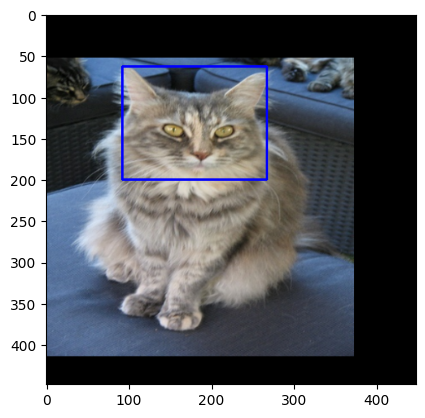

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


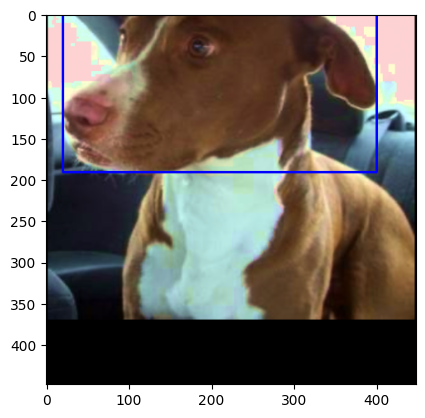

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


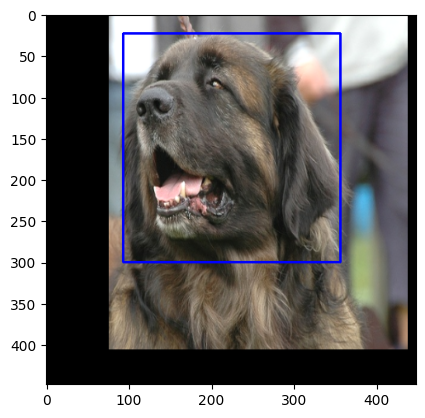

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


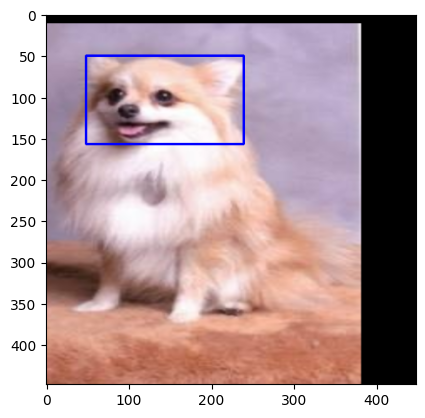

In [12]:
imgs, labs = train_iter.next()
t_imgs, lab_mat, t_boxes = compute_aug_img_and_label_mat(imgs, labs, c_num = h_params['CLS_NUM'], g_num = h_params['GRID_NUM'], transform = transform)

for i in range(h_params['BATCH']):

    draw_img = copy.deepcopy(t_imgs[i])
    
    cvt_lab_mat = cvt_cell_ratio_to_img_ratio(np.expand_dims(lab_mat[i,:,:,:], 0), c_num = 2)
    y_boxes = []
    for j in range(GRID_NUM):
        for k in range(GRID_NUM):
            if cvt_lab_mat[0, j, k, 1] == 1:
                y_boxes.append(cvt_lab_mat[0, j, k, 2:])
    y_boxes = np.array(y_boxes)
    draw_img = visualise_boxes(draw_img, 
                               yolo2minmax(y_boxes,
                                           t_imgs[i].shape[1], 
                                           t_imgs[i].shape[0]))
    plt.imshow(draw_img)
    plt.show()
